<a name="predictive-model"></a>
## Module 3: Using time-series forecasting to predict overdose deaths

<strong>SUMMARY:</strong> I'm attempting to use time-series analysis to predict future opioid deaths in the province of Ontario based on historical data. I have three slightly different datasets offering different perspectives on the data:

<ul>
    <li>Dataset A: This dataset tracks all monthly Emergency department visits, all hospitalizations and all deaths in the period Jan 2003 to Sep 2019. It includes raw numbers on visits, hospitalizations and deaths as well as the provincial crude rate (persons per 100,000). There are 201 observations and 6 features (not including date which will be used as the index)</li>
    <li>Dataset B: This version of the data adds in data on numbers of Naloxone Kits distributed, volume of opioid prescribers and prescriptions by opioid type, number of safer injection site visits (Toronto only) and number of overdoses at that site. There are only 7 observations as I don't have the a lot of the data more granularly than annual. There are 24 features (not including date which would be used as the index).</li>
    <li>Dataset C: This is a stripped down version of Dataset A with only the death counts. My thinking is to try univariate time-series forecasting on it, and multivariate time-series forecasting on Dataset A. Like Dataset A, it has 201 observations, but only 1 feature.</li>
    
In all cases, I'm not sure how well a model will perform given the relatively low number of observations in the data.
    
## Imports

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from pmdarima.arima import auto_arima, ADFTest
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

register_matplotlib_converters()

## Functions

In [3]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    
    """Credit: Selva Prabhakaran. Perform ADFuller to test for stationarity of given 
    *  series and print report
    """
    
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summarize the results
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
                
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  


## Univariate Time Series

In [4]:
# Load and visualize the data

df = pd.read_csv('csv/predictive-model/Dataset_C.csv')
df['Month'] = pd.to_datetime(df['Month'])
df = df.rename(columns = {'Month': 'Date'})
df = df.set_index('Date')
df.shape

(201, 1)

<IPython.core.display.Javascript object>


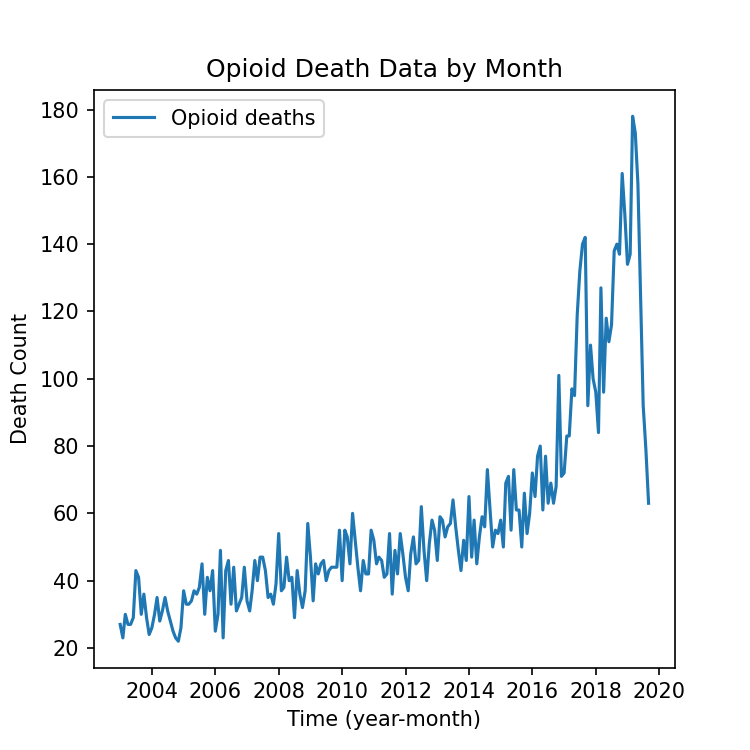

In [199]:
# Visualize the time series

plt.figure(figsize=(5, 5))
plt.plot(df['Deaths_count'], label="Opioid deaths")
plt.title('Opioid Death Data by Month')
plt.xlabel('Time (year-month)')
plt.ylabel('Death Count')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


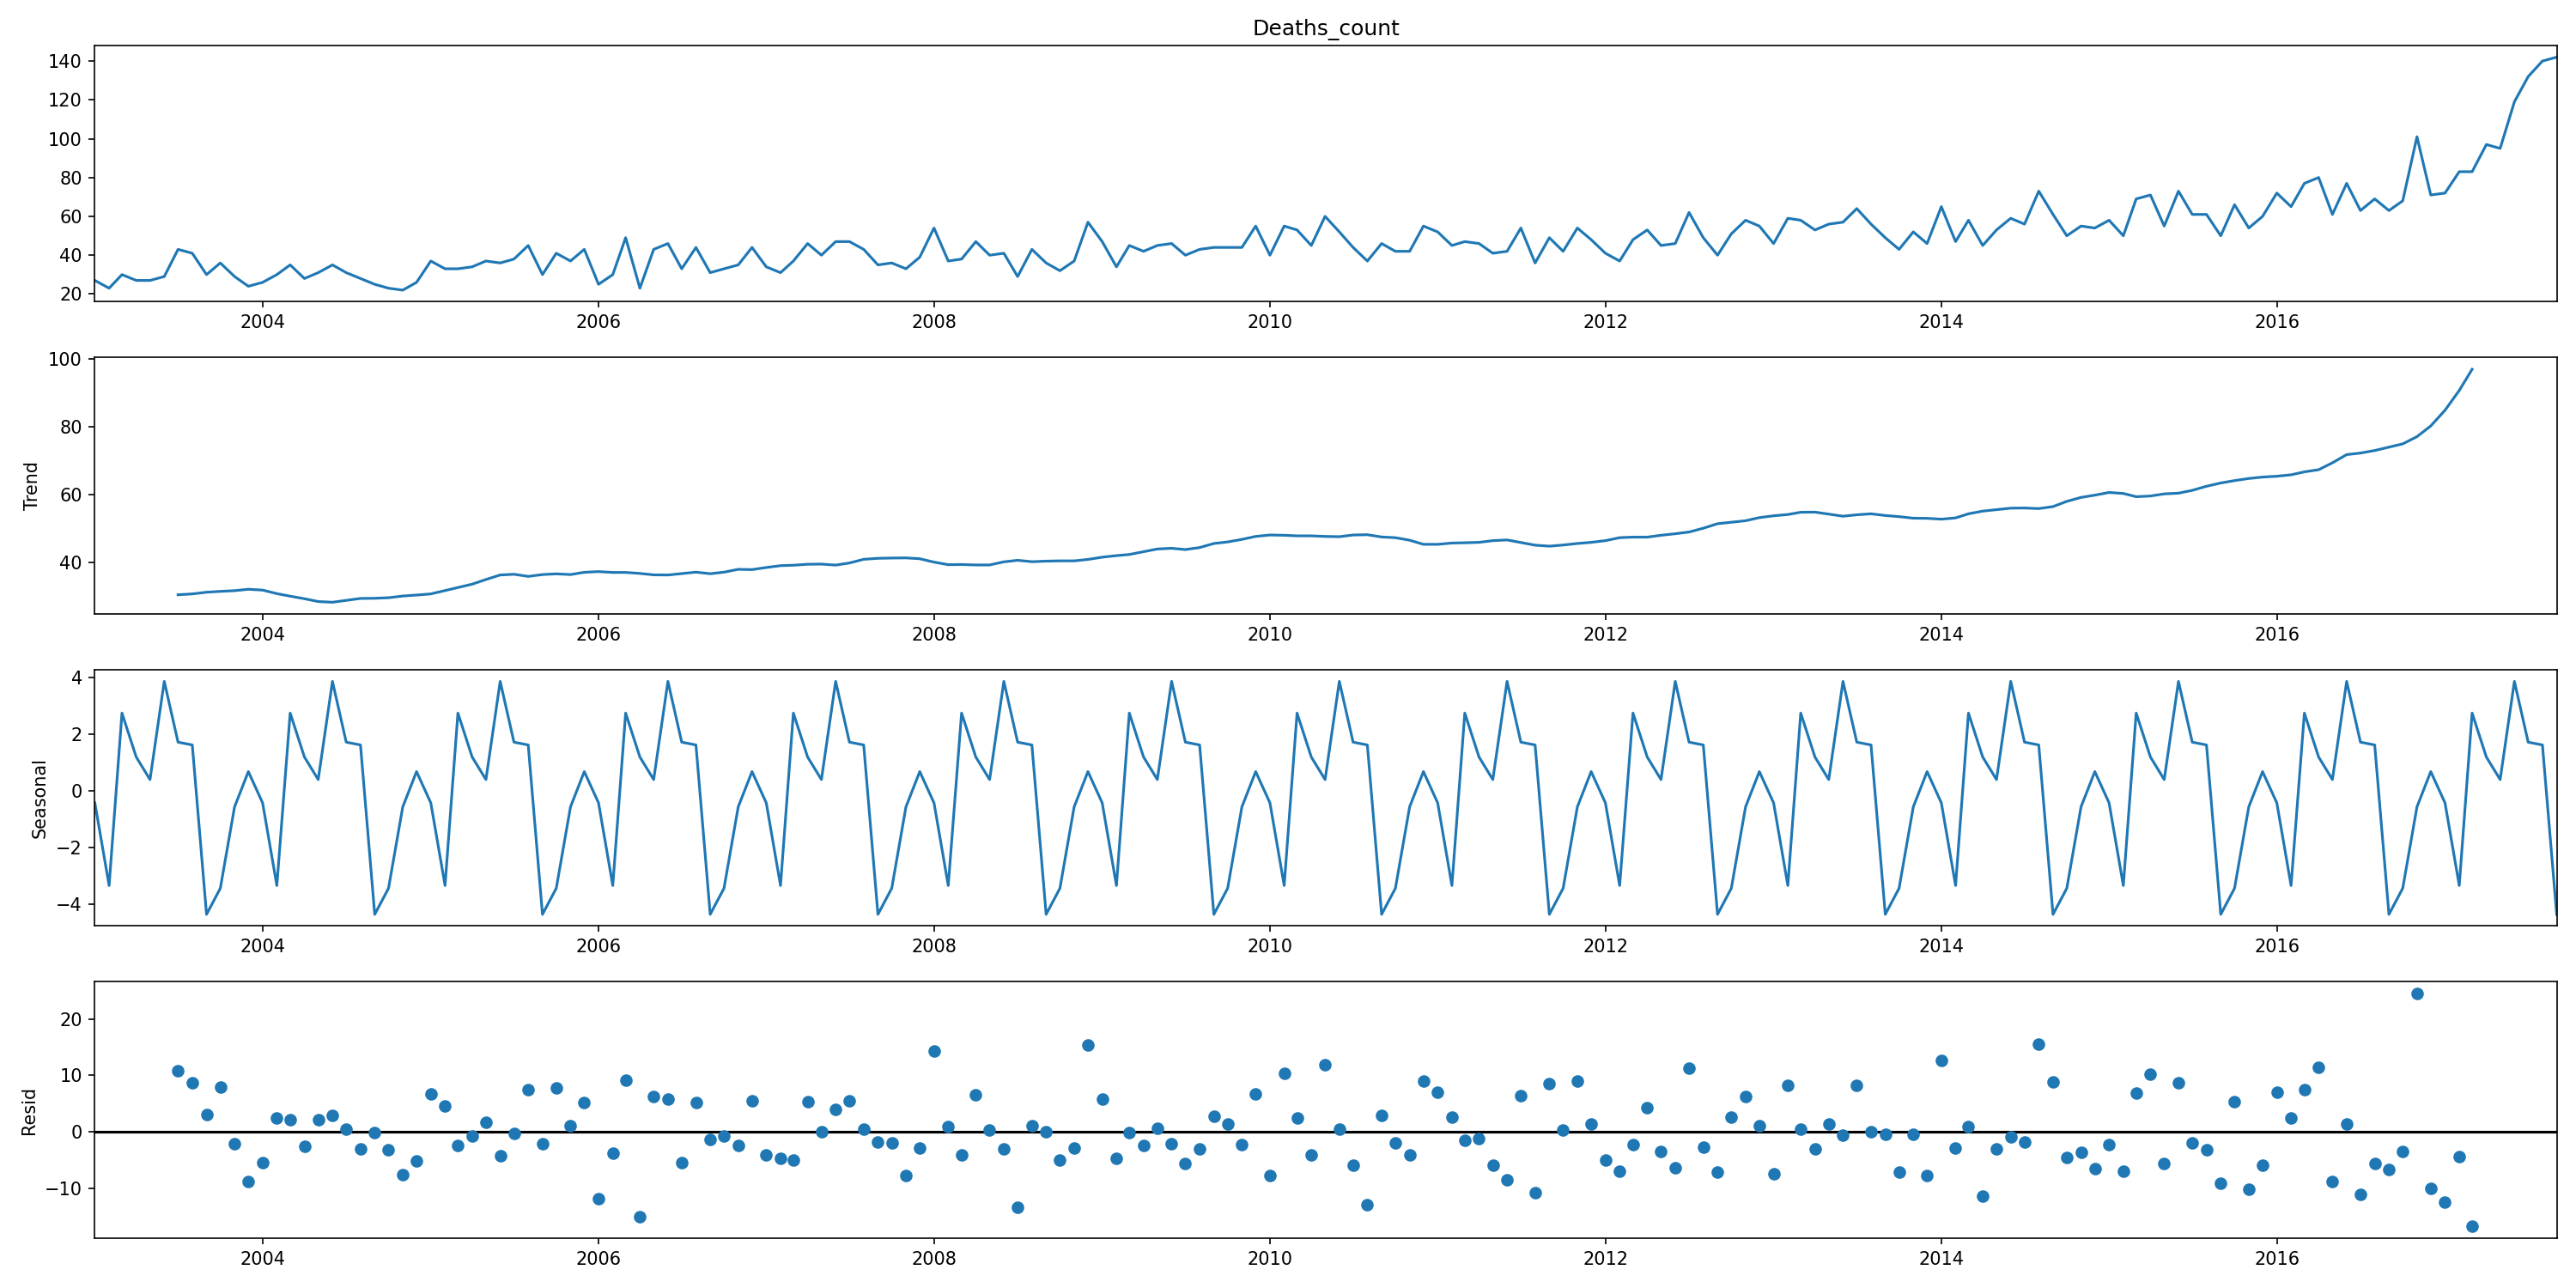

<function matplotlib.pyplot.show(*args, **kw)>

In [200]:
# Any insights from seasonal decomposition?

sm.tsa.seasonal_decompose(train.Deaths_count).plot()
result = sm.tsa.stattools.adfuller(train.Deaths_count)
plt.show

In [201]:
# To be used in time-series modeling and forecasting, data should 
# be stationary, ie. mathematically transformed to remove trend
# and seasonality.

# Let's use the Augmented Dickey-Fuller Test to check seasonality

adfuller_test(df, name = 'Original Dataset')    

    Augmented Dickey-Fuller Test on "Original Dataset" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.1476
 No. Lags Chosen       = 11
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.9692. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [202]:
# Separate the data into training and validation sets

train = df.loc['2003-01-01':'2017-09-01']
validation = df.loc['2017-10-01':'2019-09-01'] # 2 years of data

<IPython.core.display.Javascript object>


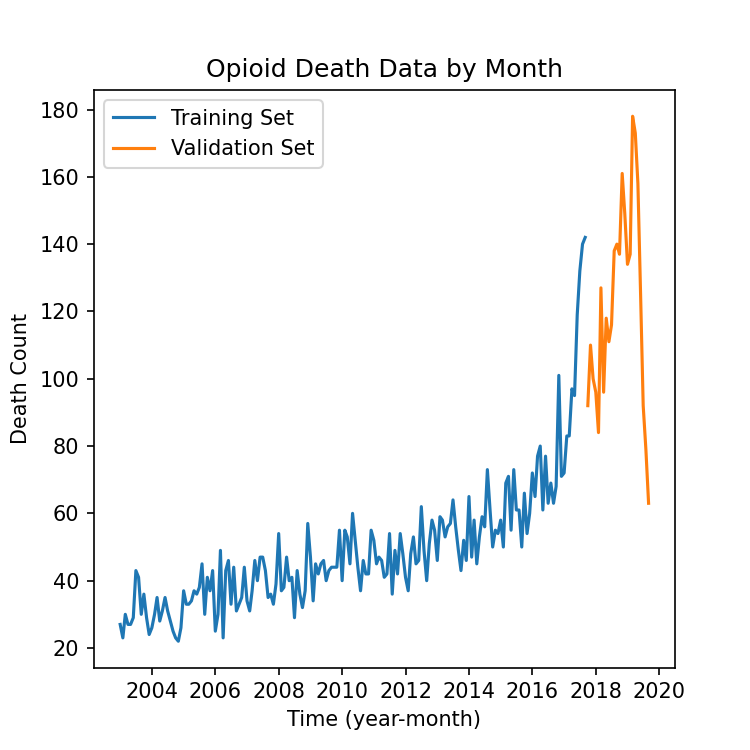

In [203]:
# Have a look

plt.figure(figsize=(5, 5))
plt.plot(train, label='Training Set')
plt.plot(validation, label='Validation Set')
plt.title('Opioid Death Data by Month')
plt.xlabel('Time (year-month)')
plt.ylabel('Death Count')
plt.legend(loc='best')

In [204]:
# Differencing is one way to make data stationary, 
# and taking the log can help remove trends.

train_transformed = train.diff().dropna()
validation_transformed = validation.diff().dropna()

<IPython.core.display.Javascript object>


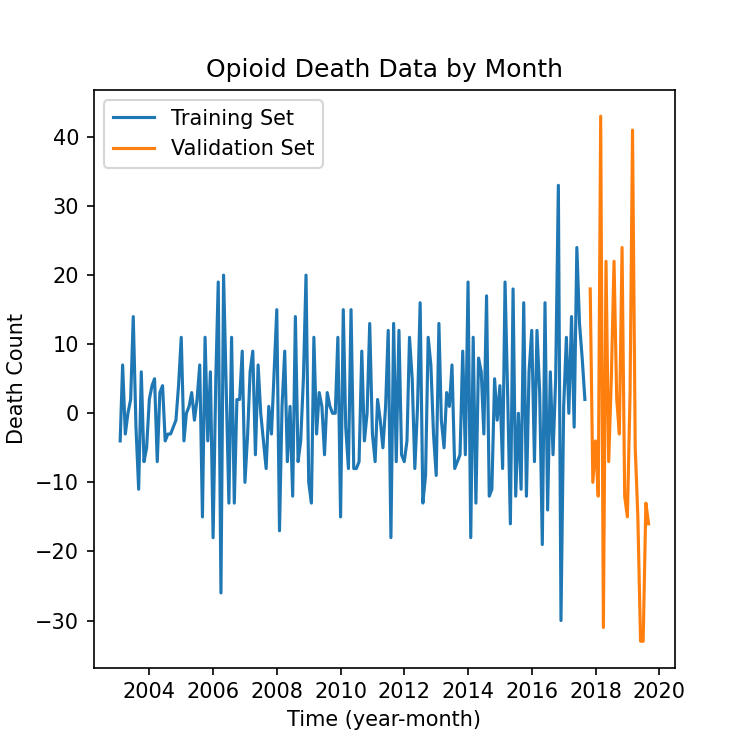

In [205]:
# Have a look again

plt.figure(figsize=(5, 5))
plt.plot(train_transformed, label='Training Set')
plt.plot(validation_transformed, label='Validation Set')
plt.title('Opioid Death Data by Month')
plt.xlabel('Time (year-month)')
plt.ylabel('Death Count')
plt.legend(loc='best')

In [133]:
# Not so sure about seasonality but it looks more level in general.
# Recheck with adfuller test

adfuller_test(train_transformed, name = 'Deaths Count Training Set')

    Augmented Dickey-Fuller Test on "Deaths Count Training Set" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0646
 No. Lags Chosen       = 5
 Critical value 1%     = -3.469
 Critical value 5%     = -2.879
 Critical value 10%    = -2.576
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [134]:
# Now check the validation set

adfuller_test(validation_transformed, name = 'Deaths Count Validation Set')

    Augmented Dickey-Fuller Test on "Deaths Count Validation Set" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0136
 No. Lags Chosen       = 0
 Critical value 1%     = -3.77
 Critical value 5%     = -3.005
 Critical value 10%    = -2.643
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [206]:
# Given what we see, let's try a **seasonal** ARIMA model
# But which one. See what auto_arima suggests

auto_arima_model = auto_arima(train, start_p = 0, start_d = 1, start_q = 0, 
                         max_p = 5, max_d = 5, max_q = 5,
                        start_P = 0, start_D = 1, start_Q = 0, 
                         max_P = 5, max_D = 5, max_Q = 5,
                        m = 12, seasonal = True, error_action = 'warn',
                        trace = True, supress_warnings = True, 
                         stepwise = True, random_state = 667, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1313.093, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1276.333, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1265.447, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1311.846, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1265.850, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1267.094, Time=0.17 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1267.383, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1265.518, Time=0.09 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1269.061, Time=0.61 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1311.003, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1266.872, Time=0.15 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1266.574, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1276.260, Time=0.14 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1268.353, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1

In [207]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  177
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -628.724
Date:                            Sun, 13 Sep 2020   AIC                           1265.447
Time:                                    17:52:13   BIC                           1278.129
Sample:                                         0   HQIC                          1270.591
                                            - 177                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6644      0.390      1.703      0.089      -0.100       1.429
ma.L1         -0.5312      0.045    -11.810      0.000      -0.619      -0.443
ma.S.L12       0.1402      0.096      1.467      0.142      -0.047       0.327
sigma2        73.9532      7.276     10.164      0.000      59.693      88.213
===================================================================================
Ljung-Box (Q):                       37.88   Jarque-Bera (JB):                26.59
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make a prediction

In [208]:
validation_prediction = pd.DataFrame(auto_arima_model.predict(n_periods = 24),index=validation.index)
validation_prediction.columns = ['Deaths_count']
validation_prediction

,Deaths_count
Date,
2017-10-01,135.861211
2017-11-01,141.316087
2017-12-01,137.575125
2018-01-01,138.065485
2018-02-01,140.313319
2018-03-01,140.708207
2018-04-01,143.204656
2018-05-01,143.833422
2018-06-01,147.513274


<IPython.core.display.Javascript object>


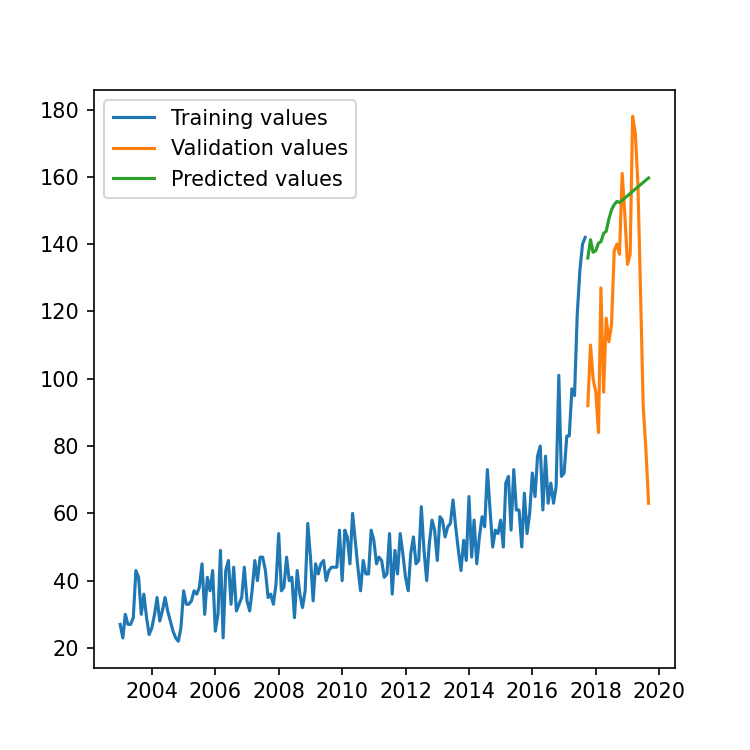

In [209]:
plt.figure(figsize=(5,5))
plt.plot(train,label="Training values")
plt.plot(validation,label="Validation values")
plt.plot(validation_prediction,label="Predicted values")
plt.legend(loc = 'best')
plt.show()

## Time-series 2: Multivariate

In [5]:
# Load and visualize the data

df = pd.read_csv('csv/predictive-model/Dataset_A.csv')
df['Month'] = pd.to_datetime(df['Month'])
df = df.rename(columns = {'Month': 'Date'})
df = df.set_index('Date')
df.shape

(201, 6)

<IPython.core.display.Javascript object>


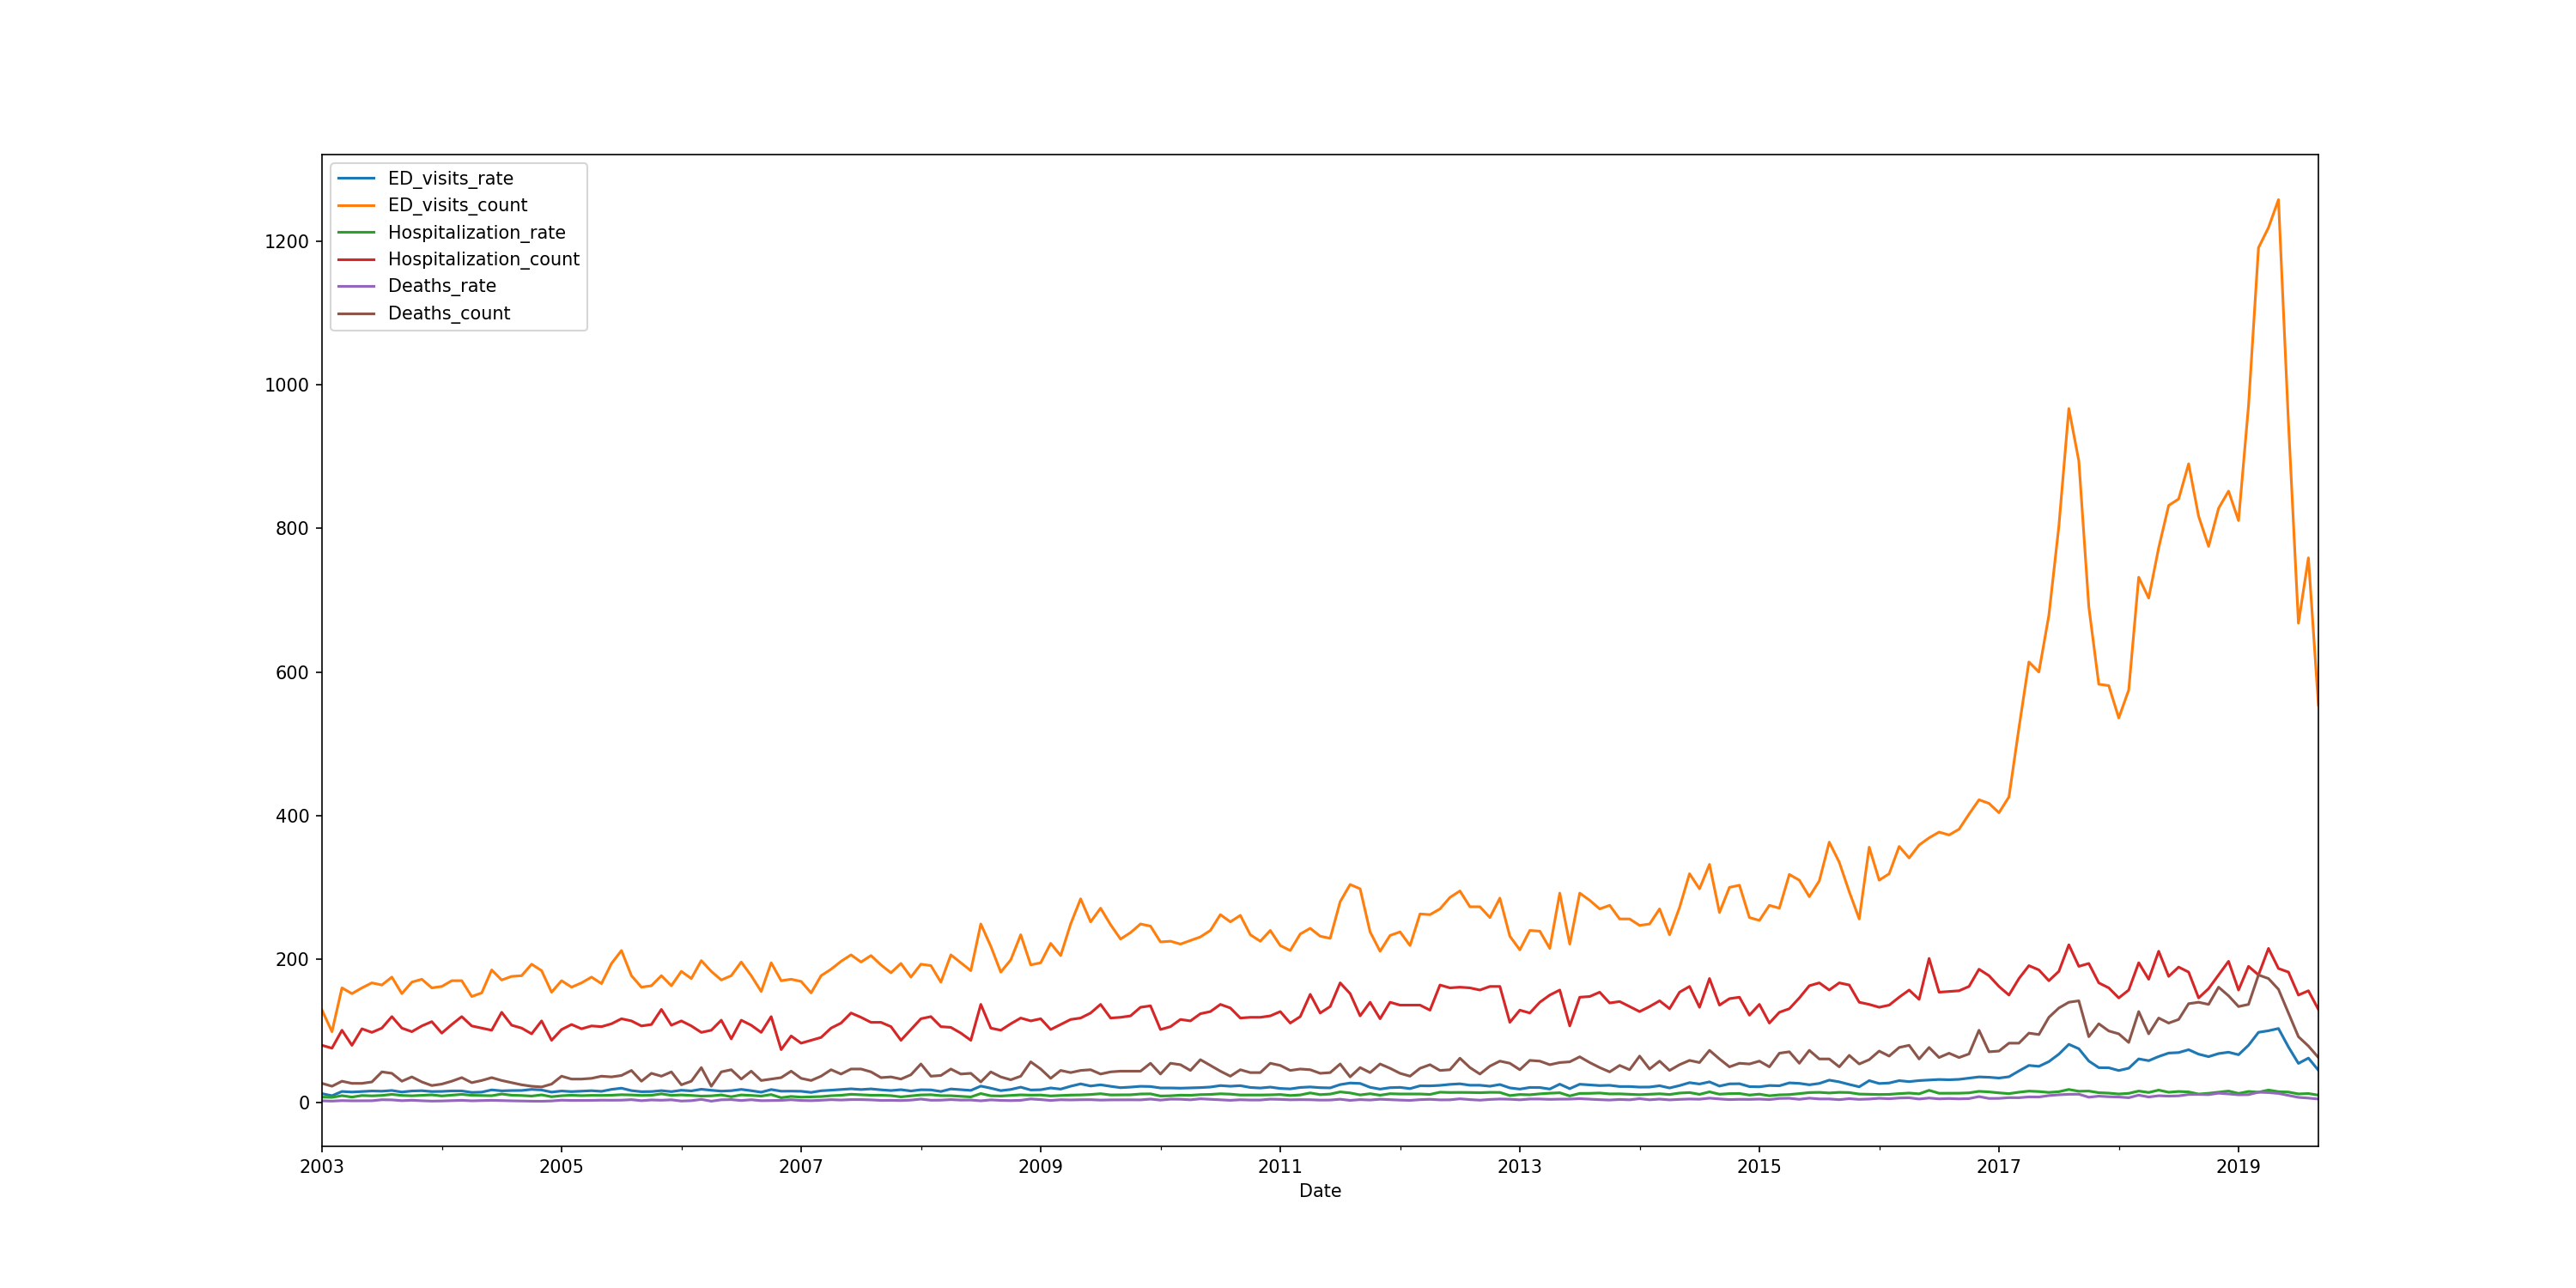

In [164]:
# Visualize the time series

df.plot()

# plt.figure(figsize=(5, 5))
# # plt.plot(df['Deaths_count'], label="Opioid deaths")
# plt.title('Opioid Death Data by Month')
# plt.xlabel('Time (year-month)')
# plt.ylabel('Death Count')
# plt.legend(loc='best')

In [162]:
df

,ED_visits_rate,ED_visits_count,Hospitalization_rate,Hospitalization_count,Deaths_rate,Deaths_count
Date,,,,,,
2003-01-01,12.7,129,7.9,80,2.7,27
2003-01-02,9.8,99,7.5,76,2.3,23
2003-01-03,15.7,160,9.9,101,3.0,30
2003-01-04,14.9,152,7.9,80,2.7,27
2003-01-05,15.7,160,10.1,103,2.7,27
2003-01-06,16.4,167,9.6,98,2.8,29
2003-01-07,16.1,164,10.2,104,4.2,43
2003-01-08,17.1,175,11.7,120,4.0,41
2003-01-09,14.9,152,10.2,104,2.9,30


In [177]:
# Separate the data into training and validation sets

train = df.loc['2003-01-01':'2017-09-01']
validation = df.loc['2017-10-01':'2019-09-01'] # 2 years of data

From here I tried a number of approaches to get the data stationary, but it resisted. This will be an ongoing focus of effort, and I will update the Github once it is sorted. 